# Invasive Devices
Feature Engineering: Invasive Devices



Load libraries and setup environment

In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
from sklearn.manifold import TSNE

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

MIMIC BigQuery access

In [ ]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# authenticate
auth.authenticate_user()

# MIMIC project ID
project_id = "ml-health-395010"

MIMIC IV setup (MIMIC IV version 2.2)

In [ ]:
# CODE TAKEN FROM TUTORIAL 3
# accessed at: 14-08-2023

# Set up environment variables
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## HAI Positives
Load HAI positives dataset

In [ ]:
HAI_POS_PATH = "/content/drive/MyDrive/ML Health/proposal/HAI Positive Patients.csv"

hai_pos_df = pd.read_csv(HAI_POS_PATH)
hai_pos_df

,subject_id,hadm_id,stay_id,icd_code,long_title,HAI_Type
0,10007818,22987108,32359580.0,T80219A,Unspecified infection due to central venous ca...,CLABSI
1,10785126,20598872,39785361.0,T80211D,Bloodstream infection due to central venous ca...,CLABSI
2,10207354,24602624,NaN,T80219A,Unspecified infection due to central venous ca...,CLABSI
3,11624559,29387474,NaN,T80218A,Other infection due to central venous catheter...,CLABSI
4,11864591,27843066,NaN,T83510A,Infection and inflammatory reaction due to cys...,CAUTI
...,...,...,...,...,...,...
5564,13766350,26137394,30935196.0,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
5565,12200502,29234722,32185728.0,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
5566,12200502,29234722,39773284.0,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
5567,11708854,20452061,NaN,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI


remove null stay_id

In [ ]:
hai_pos_df = hai_pos_df[hai_pos_df['stay_id'].notna()]
hai_pos_df = hai_pos_df.reset_index(drop=True)
hai_pos_df["stay_id"] = pd.to_numeric(hai_pos_df["stay_id"], downcast='integer')
hai_pos_df

,subject_id,hadm_id,stay_id,icd_code,long_title,HAI_Type
0,10007818,22987108,32359580,T80219A,Unspecified infection due to central venous ca...,CLABSI
1,10785126,20598872,39785361,T80211D,Bloodstream infection due to central venous ca...,CLABSI
2,12297168,28749499,33007017,T80218A,Other infection due to central venous catheter...,CLABSI
3,12490029,26495589,33759728,T83510A,Infection and inflammatory reaction due to cys...,CAUTI
4,14471034,24151113,39723144,T80218A,Other infection due to central venous catheter...,CLABSI
...,...,...,...,...,...,...
3410,15616719,26378988,32812963,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
3411,13766350,26137394,36527141,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
3412,13766350,26137394,30935196,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI
3413,12200502,29234722,32185728,T8351XA,Infection and inflammatory reaction due to ind...,CAUTI


types of HAI

In [ ]:
hai_pos_df["HAI_Type"].unique()

array(['CLABSI', 'CAUTI', 'VAP'], dtype=object)

HAI as label

In [ ]:
hai_pos_df = hai_pos_df[["stay_id", "HAI_Type"]]
hai_pos_df

,stay_id,HAI_Type
0,32359580,CLABSI
1,39785361,CLABSI
2,33007017,CLABSI
3,33759728,CAUTI
4,39723144,CLABSI
...,...,...
3410,32812963,CAUTI
3411,36527141,CAUTI
3412,30935196,CAUTI
3413,32185728,CAUTI


## Ventilator-Associated Pneumonia (VAP)

In [ ]:
vap = """
SELECT
    tm.stay_id,
    CASE
        WHEN ventilator_mode is not null THEN ventilator_mode
        WHEN ventilator_mode_hamilton is not null THEN ventilator_mode_hamilton
        ELSE null
    END as vent_type,
    MIN(tm.charttime) as starttime,
    MAX(tm.charttime) as endtime,
    o2_delivery_device_1 as vent_o2_device,

    avg(o2_flow) as avg_o2_flow,
    avg(o2_flow_additional) as avg_o2_flow_additional,
    min(o2_flow) as min_o2_flow,
    min(o2_flow_additional) as min_o2_flow_additional,
    max(o2_flow) as max_o2_flow,
    max(o2_flow_additional) as max_o2_flow_additional,
    stddev(o2_flow) as stddev_o2_flow,
    stddev(o2_flow_additional) as stddev_o2_flow_additional,
    APPROX_QUANTILES(o2_flow, 4)[OFFSET(1)] as q1_o2_flow,
    APPROX_QUANTILES(o2_flow_additional, 4)[OFFSET(1)] as q1_o2_flow_additional,
    APPROX_QUANTILES(o2_flow, 4)[OFFSET(3)] as q3_o2_flow,
    APPROX_QUANTILES(o2_flow_additional, 4)[OFFSET(3)] as q3_o2_flow_additional,

    avg(respiratory_rate_set) as avg_respiratory_rate_set,
    avg(respiratory_rate_total) as avg_respiratory_rate_total,
    avg(respiratory_rate_spontaneous) as avg_respiratory_rate_spontaneous,
    avg(minute_volume) as avg_minute_volume,
    avg(tidal_volume_set) as avg_tidal_volume_set,
    avg(tidal_volume_observed) as avg_tidal_volume_observed,
    avg(tidal_volume_spontaneous) as avg_tidal_volume_spontaneous,
    avg(plateau_pressure) as avg_plateau_pressure,
    avg(peep) as avg_peep,
    avg(fio2) as avg_fio2,
    avg(flow_rate) as avg_flow_rate,
    min(respiratory_rate_set) as min_respiratory_rate_set,
    min(respiratory_rate_total) as min_respiratory_rate_total,
    min(respiratory_rate_spontaneous) as min_respiratory_rate_spontaneous,
    min(minute_volume) as min_minute_volume,
    min(tidal_volume_set) as min_tidal_volume_set,
    min(tidal_volume_observed) as min_tidal_volume_observed,
    min(tidal_volume_spontaneous) as min_tidal_volume_spontaneous,
    min(plateau_pressure) as min_plateau_pressure,
    min(peep) as min_peep,
    min(fio2) as min_fio2,
    min(flow_rate) as min_flow_rate,
    max(respiratory_rate_set) as max_respiratory_rate_set,
    max(respiratory_rate_total) as max_respiratory_rate_total,
    max(respiratory_rate_spontaneous) as max_respiratory_rate_spontaneous,
    max(minute_volume) as max_maxute_volume,
    max(tidal_volume_set) as max_tidal_volume_set,
    max(tidal_volume_observed) as max_tidal_volume_observed,
    max(tidal_volume_spontaneous) as max_tidal_volume_spontaneous,
    max(plateau_pressure) as max_plateau_pressure,
    max(peep) as max_peep,
    max(fio2) as max_fio2,
    max(flow_rate) as max_flow_rate,
    stddev(respiratory_rate_set) as stddev_respiratory_rate_set,
    stddev(respiratory_rate_total) as stddev_respiratory_rate_total,
    stddev(respiratory_rate_spontaneous) as stddev_respiratory_rate_spontaneous,
    stddev(minute_volume) as stddev_stddevute_volume,
    stddev(tidal_volume_set) as stddev_tidal_volume_set,
    stddev(tidal_volume_observed) as stddev_tidal_volume_observed,
    stddev(tidal_volume_spontaneous) as stddev_tidal_volume_spontaneous,
    stddev(plateau_pressure) as stddev_plateau_pressure,
    stddev(peep) as stddev_peep,
    stddev(fio2) as stddev_fio2,
    stddev(flow_rate) as stddev_flow_rate,
    APPROX_QUANTILES(respiratory_rate_set, 4)[offset(1)] as q1_respiratory_rate_set,
    APPROX_QUANTILES(respiratory_rate_total, 4)[offset(1)] as q1_respiratory_rate_total,
    APPROX_QUANTILES(respiratory_rate_spontaneous, 4)[offset(1)] as q1_respiratory_rate_spontaneous,
    APPROX_QUANTILES(minute_volume, 4)[offset(1)] as q1_stddevute_volume,
    APPROX_QUANTILES(tidal_volume_set, 4)[offset(1)] as q1_tidal_volume_set,
    APPROX_QUANTILES(tidal_volume_observed, 4)[offset(1)] as q1_tidal_volume_observed,
    APPROX_QUANTILES(tidal_volume_spontaneous, 4)[offset(1)] as q1_tidal_volume_spontaneous,
    APPROX_QUANTILES(plateau_pressure, 4)[offset(1)] as q1_plateau_pressure,
    APPROX_QUANTILES(peep, 4)[offset(1)] as q1_peep,
    APPROX_QUANTILES(fio2, 4)[offset(1)] as q1_fio2,
    APPROX_QUANTILES(flow_rate, 4)[offset(1)] as q1_flow_rate,
    APPROX_QUANTILES(respiratory_rate_set, 4)[offset(3)] as q3_respiratory_rate_set,
    APPROX_QUANTILES(respiratory_rate_total, 4)[offset(3)] as q3_respiratory_rate_total,
    APPROX_QUANTILES(respiratory_rate_spontaneous, 4)[offset(3)] as q3_respiratory_rate_spontaneous,
    APPROX_QUANTILES(minute_volume, 4)[offset(3)] as q3_stddevute_volume,
    APPROX_QUANTILES(tidal_volume_set, 4)[offset(3)] as q3_tidal_volume_set,
    APPROX_QUANTILES(tidal_volume_observed, 4)[offset(3)] as q3_tidal_volume_observed,
    APPROX_QUANTILES(tidal_volume_spontaneous, 4)[offset(3)] as q3_tidal_volume_spontaneous,
    APPROX_QUANTILES(plateau_pressure, 4)[offset(3)] as q3_plateau_pressure,
    APPROX_QUANTILES(peep, 4)[offset(3)] as q3_peep,
    APPROX_QUANTILES(fio2, 4)[offset(3)] as q3_fio2,
    APPROX_QUANTILES(flow_rate, 4)[offset(3)] as q3_flow_rate,
FROM
  (
    SELECT stay_id, charttime
    FROM `physionet-data.mimiciv_derived.ventilator_setting`
    UNION DISTINCT
    SELECT stay_id, charttime
    FROM `physionet-data.mimiciv_derived.oxygen_delivery`
  ) as tm
  LEFT JOIN `physionet-data.mimiciv_derived.ventilator_setting` vs
      ON tm.stay_id = vs.stay_id
      AND tm.charttime = vs.charttime
  LEFT JOIN `physionet-data.mimiciv_derived.oxygen_delivery` od
      ON tm.stay_id = od.stay_id
      AND tm.charttime = od.charttime
WHERE
    o2_delivery_device_1 IN
    (
        'Endotracheal tube'
    )
    OR ventilator_mode IN
    (
        '(S) CMV',
        'APRV',
        'APRV/Biphasic+ApnPress',
        'APRV/Biphasic+ApnVol',
        'APV (cmv)',
        'Ambient',
        'Apnea Ventilation',
        'CMV',
        'CMV/ASSIST',
        'CMV/ASSIST/AutoFlow',
        'CMV/AutoFlow',
        'CPAP/PPS',
        'CPAP/PSV+Apn TCPL',
        'CPAP/PSV+ApnPres',
        'CPAP/PSV+ApnVol',
        'MMV',
        'MMV/AutoFlow',
        'MMV/PSV',
        'MMV/PSV/AutoFlow',
        'P-CMV',
        'PCV+',
        'PCV+/PSV',
        'PCV+Assist',
        'PRES/AC',
        'PRVC/AC',
        'PRVC/SIMV',
        'PSV/SBT',
        'SIMV',
        'SIMV/AutoFlow',
        'SIMV/PRES',
        'SIMV/PSV',
        'SIMV/PSV/AutoFlow',
        'SIMV/VOL',
        'SYNCHRON MASTER',
        'SYNCHRON SLAVE',
        'VOL/AC'
    )
    OR ventilator_mode_hamilton IN
    (
        'APRV',
        'APV (cmv)',
        'Ambient',
        '(S) CMV',
        'P-CMV',
        'SIMV',
        'APV (simv)',
        'P-SIMV',
        'VS',
        'ASV'
    )
GROUP BY
    tm.stay_id, vent_type, o2_delivery_device_1
HAVING
    -- type is not null
    -- o2_delivery_device_1 is not null
    MIN(tm.charttime) != MAX(tm.charttime)
-- LIMIT 1000
;
"""

In [ ]:
vap_df_ori = run_query(vap)
vap_df_ori

,stay_id,vent_type,starttime,endtime,vent_o2_device,avg_o2_flow,avg_o2_flow_additional,min_o2_flow,min_o2_flow_additional,max_o2_flow,...,q3_respiratory_rate_total,q3_respiratory_rate_spontaneous,q3_stddevute_volume,q3_tidal_volume_set,q3_tidal_volume_observed,q3_tidal_volume_spontaneous,q3_plateau_pressure,q3_peep,q3_fio2,q3_flow_rate
0,31817310,None,2142-09-06 16:50:00,2142-09-06 17:00:00,Endotracheal tube,5.000000,2.0,5.0,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN
1,30984075,None,2187-08-17 07:49:00,2187-08-17 15:08:00,Endotracheal tube,3.000000,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36797478,None,2173-10-28 06:28:00,2173-10-29 13:00:00,Endotracheal tube,3.333333,NaN,2.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30467431,None,2166-04-02 08:03:00,2166-04-02 17:39:00,Endotracheal tube,2.000000,NaN,2.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33931625,None,2145-07-07 10:55:00,2145-07-07 12:00:00,Endotracheal tube,3.000000,NaN,2.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31164,31167872,CMV/ASSIST/AutoFlow,2117-09-23 16:00:00,2117-09-24 07:00:00,None,NaN,NaN,NaN,NaN,NaN,...,18.0,0.0,6.84,400.0,398.0,NaN,20.0,5.0,50.0,NaN
31165,31841472,CMV/ASSIST/AutoFlow,2164-03-22 00:00:00,2164-03-22 12:00:00,None,NaN,NaN,NaN,NaN,NaN,...,20.0,0.0,7.30,400.0,377.0,NaN,20.0,6.0,35.0,NaN
31166,37958127,CMV/ASSIST/AutoFlow,2169-11-29 12:23:00,2169-11-30 11:00:00,None,NaN,NaN,NaN,NaN,NaN,...,16.0,0.0,8.50,500.0,546.0,NaN,21.0,9.0,100.0,NaN
31167,32351673,CMV/ASSIST/AutoFlow,2115-09-04 12:00:00,2115-09-04 16:00:00,None,NaN,NaN,NaN,NaN,NaN,...,12.0,0.0,7.20,550.4,574.0,428.0,NaN,5.0,100.0,NaN


Note:
- type is the ventilator mode
- value will be the oxygen delivery device

count missing value

In [ ]:
vap_df = vap_df_ori.copy()
vap_df[vap_df['vent_o2_device'].isna()].shape[0]

31019

create feature

In [ ]:
# calc duration
vap_df["duration"] = (vap_df["endtime"] - vap_df["starttime"]).dt.total_seconds()
vap_df = vap_df.drop('endtime',axis = 1)
vap_df = vap_df.drop('starttime',axis = 1)

# one-hot-encoding
for col in ["vent_type", "vent_o2_device"]:
  one_hot = pd.get_dummies(vap_df[col])
  one_hot.columns = [col + "-" + c.lower().replace(" ", "_") for c in list(one_hot.columns)]
  vap_df = vap_df.drop(col,axis = 1)
  vap_df = vap_df.join(one_hot)

# vap_df
vap_df

,stay_id,avg_o2_flow,avg_o2_flow_additional,min_o2_flow,min_o2_flow_additional,max_o2_flow,max_o2_flow_additional,stddev_o2_flow,stddev_o2_flow_additional,q1_o2_flow,...,vent_type-vol/ac,vent_type-vs,vent_o2_device-aerosol-cool,vent_o2_device-endotracheal_tube,vent_o2_device-high_flow_nasal_cannula,vent_o2_device-high_flow_neb,vent_o2_device-nasal_cannula,vent_o2_device-t-piece,vent_o2_device-trach_mask_,vent_o2_device-tracheostomy_tube
0,31817310,5.000000,2.0,5.0,2.0,5.0,2.0,NaN,NaN,5.0,...,0,0,0,1,0,0,0,0,0,0
1,30984075,3.000000,3.0,3.0,3.0,3.0,3.0,NaN,NaN,3.0,...,0,0,0,1,0,0,0,0,0,0
2,36797478,3.333333,NaN,2.0,NaN,4.0,NaN,1.154701,NaN,2.0,...,0,0,0,1,0,0,0,0,0,0
3,30467431,2.000000,NaN,2.0,NaN,2.0,NaN,0.000000,NaN,2.0,...,0,0,0,1,0,0,0,0,0,0
4,33931625,3.000000,NaN,2.0,NaN,4.0,NaN,1.414214,NaN,2.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31164,31167872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
31165,31841472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
31166,37958127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
31167,32351673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# save feature
vap_df.to_csv('/content/drive/MyDrive/ML Health/proposal/VAP_invasive_new.csv', index=False)

join with label

In [ ]:
vap_df = vap_df.join(hai_pos_df.set_index("stay_id"), on='stay_id')
vap_df["label"] = vap_df["HAI_Type"].apply(lambda x: 1 if x == "VAP" else 0)

vap_df = vap_df.drop('stay_id',axis = 1)
vap_df = vap_df.drop('HAI_Type',axis = 1)

print(vap_df["label"].sum())

vap_df

3703


,duration,type-(s)_cmv,type-aprv,type-aprv/biphasic+apnpress,type-aprv/biphasic+apnvol,type-apv_(cmv),type-apv_(simv),type-asv,type-ambient,type-apnea_ventilation,...,type-vs,value-aerosol-cool,value-endotracheal_tube,value-high_flow_nasal_cannula,value-high_flow_neb,value-nasal_cannula,value-t-piece,value-trach_mask_,value-tracheostomy_tube,label
0,3600.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7860.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,36000.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
3,600.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,10260.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31164,5520.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31165,10800.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31166,14400.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31167,5160.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


feature importance

[Text(0.5, 1.0, 'correlation between feature')]

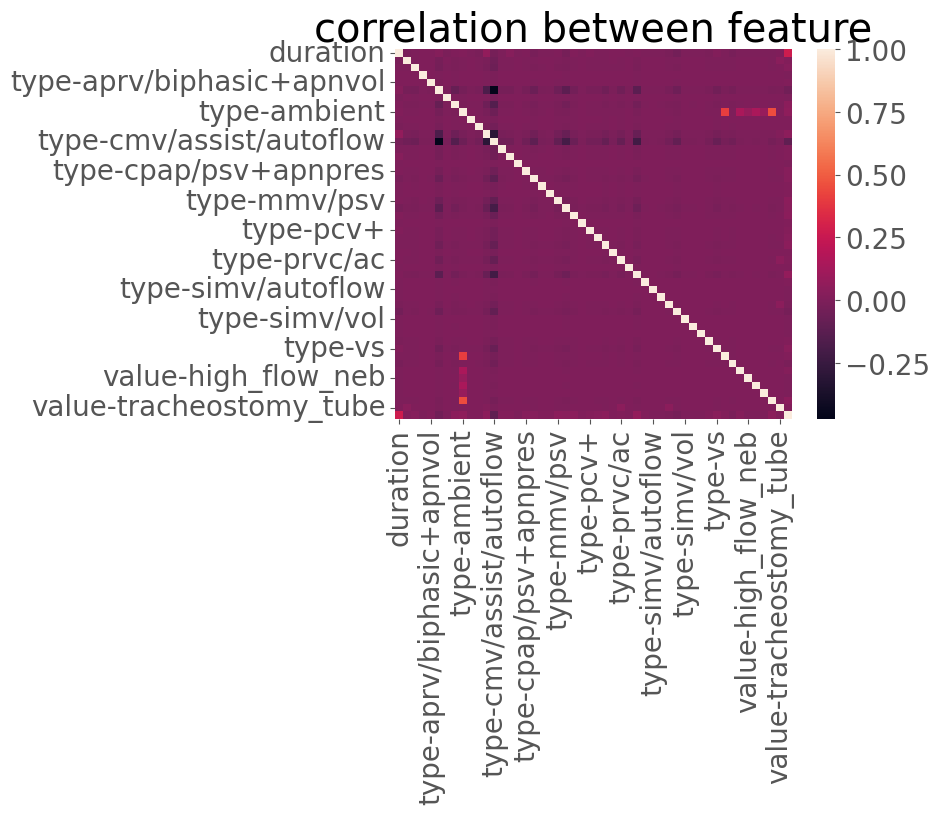

In [ ]:
# correlation heatmap
sns.heatmap(vap_df.corr(), annot=False).set(title="correlation between feature")

In [ ]:
# rank correlation to label
vap_df.corr().loc["label", :].sort_values(ascending=False)

label                            1.000000
duration                         0.271959
type-psv/sbt                     0.067855
type-ambient                     0.050500
type-cmv/assist                  0.047921
type-asv                         0.044619
type-mmv/psv                     0.044450
type-p-cmv                       0.043681
value-trach_mask_                0.042011
type-pcv+assist                  0.041107
type-vs                          0.038653
type-mmv/psv/autoflow            0.034230
type-pcv+/psv                    0.029019
type-cpap/psv+apnpres            0.027328
type-aprv                        0.023426
type-cpap/psv+apnvol             0.023166
type-pcv+                        0.019116
value-high_flow_nasal_cannula    0.016633
value-aerosol-cool               0.014905
type-cmv/autoflow                0.012915
value-tracheostomy_tube          0.012727
type-cpap/pps                    0.011959
type-(s)_cmv                     0.010796
type-mmv                         0

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 7406 samples in 0.002s...
[t-SNE] Computed neighbors for 7406 samples in 0.382s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7406
[t-SNE] Computed conditional probabilities for sample 2000 / 7406
[t-SNE] Computed conditional probabilities for sample 3000 / 7406
[t-SNE] Computed conditional probabilities for sample 4000 / 7406
[t-SNE] Computed conditional probabilities for sample 5000 / 7406
[t-SNE] Computed conditional probabilities for sample 6000 / 7406
[t-SNE] Computed conditional probabilities for sample 7000 / 7406
[t-SNE] Computed conditional probabilities for sample 7406 / 7406
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.242935
[t-SNE] KL divergence after 1000 iterations: 0.626948


[Text(0.5, 1.0, 'VAP T-SNE projection')]

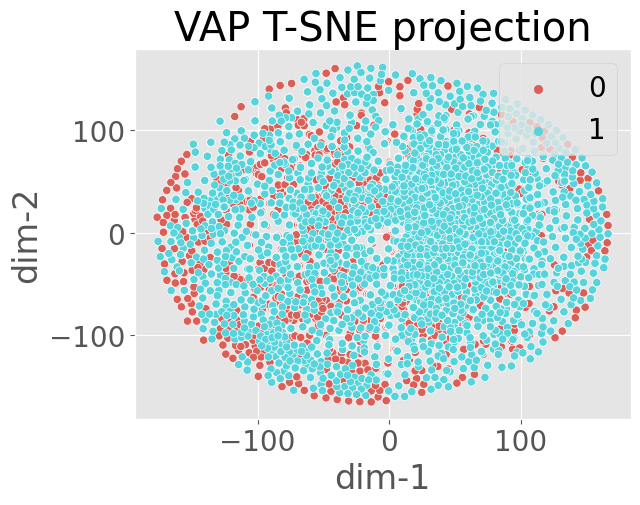

In [ ]:
# embedding visualization
sampled = vap_df.groupby('label', group_keys=False).apply(lambda x: x.sample(vap_df["label"].sum()))
X = sampled.drop('label',axis = 1)
y = sampled["label"]

tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=2, n_iter=1000)
emb = tsne.fit_transform(X)

df = pd.DataFrame({
    "y": y,
    "dim-1": emb[:, 0],
    "dim-2": emb[:, 1]
})

sns.scatterplot(
    x="dim-1",
    y="dim-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),
    data=df
).set(title="VAP T-SNE projection")

**end of code**